# Assignment 2 CNN
**Ruyu Liu**
**a1882974**

In [4]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import os
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/gx/pwy0byr15pq8m62vhfygrw8w0000gn/T/ipykernel_57640/2870729131.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [5]:
# TRANSFORMATIONS
transform = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(), # normalizes to range [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # further normalization
])

In [6]:
# LOAD THE DATA
root = '../Data/Fruit360/fruits-360_dataset/fruits-360/'

train_data = datasets.ImageFolder(os.path.join(root, 'Training'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=transform)

torch.manual_seed(42)
# BATCHSIZE = 100
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

class_names = train_data.classes

print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')
print(f'Class types available:  {len(class_names)}')

Training images available: 67692
Testing images available:  22688
Class types available:  131


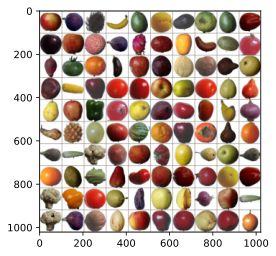

In [50]:
# IMAGE DISPLAY

for images, labels in train_loader:
    break

im = make_grid(images, nrow = 10)

inv_normalize = transforms.Normalize(
    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))
plt.savefig('DataImage_Display.png')

## Basic CNN Initial Training and Testing

In [12]:
class basicCNN(nn.Module):
    def __init__(self):
        super().__init__()

        ### -------------- feature map layers -------------- ###
        # first convolution layer
        self.conv1  = nn.Conv2d(3,32,3,stride=1)
        self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer

        # second convolution layer
        self.conv2  = nn.Conv2d(32,32,3,stride=1)
        self.bnorm2 = nn.BatchNorm2d(32) # input the number of channels in this layer
      
        # third convolution layer
        self.conv3  = nn.Conv2d(32,64,3,stride=1)
        self.bnorm3 = nn.BatchNorm2d(64) # input the number of channels in this layer


        ### -------------- linear decision layers -------------- ###
        self.fc1 = nn.Linear(10*10*64,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,131)


    def forward(self,x):
      
        # first block: convolution -> maxpool -> batchnorm -> relu
        x = F.max_pool2d(self.conv1(x),2)
        x = F.relu(self.bnorm1(x))

        # second block: convolution -> maxpool -> batchnorm -> relu
        x = F.max_pool2d(self.conv2(x),2)
        x = F.relu(self.bnorm2(x))

        # third block: convolution -> maxpool -> batchnorm -> relu
        x = F.max_pool2d(self.conv3(x),2)
        x = F.relu(self.bnorm3(x))

        # reshape for linear layer
        x = x.view(-1,10*10*64)
      
        # linear layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [13]:
# create the model instance
cnn = basicCNN()
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.01,momentum=.9)

In [14]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(cnn)

   864
    32
    32
    32
  9216
    32
    32
    32
 18432
    64
    64
    64
6553600
  1024
524288
   512
 67072
   131
______
7175523


In [17]:
import time
start_time = time.time()

numepochs = 10

# initialize losses
CtrainLoss = torch.zeros(numepochs)
CtestLoss  = torch.zeros(numepochs)
CtrainAcc  = torch.zeros(numepochs)
CtestAcc   = torch.zeros(numepochs)
Ctrain_correct = []
Ctest_correct = []


# loop over epochs
for epochi in range(numepochs):
    
    # loop over training data batches
    cnn.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    Ctrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        b += 1
        # forward pass and loss
        yHat = cnn(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        Ctrn_corr += batch_corr 
        
        # Print interim results
        if b%50 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {Ctrn_corr.item()*100/(100*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    CtrainLoss[epochi] = np.mean(batchLoss)
    CtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    cnn.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    Ctst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = cnn(X)
            loss = lossfun(yHat,y)
            Ctst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    CtestLoss[epochi] = np.mean(batchLoss)
    CtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {CtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   50 loss: 2.80482483 train accuracy:  14.200%
epoch:  0  batch:  100 loss: 1.01554143 train accuracy:  35.280%
epoch:  0  batch:  150 loss: 0.49658653 train accuracy:  50.700%
epoch:  0  batch:  200 loss: 0.31866756 train accuracy:  60.590%
epoch:  0  batch:  250 loss: 0.12873699 train accuracy:  67.284%
epoch:  0  batch:  300 loss: 0.10190260 train accuracy:  72.130%
epoch:  0  batch:  350 loss: 0.14084204 train accuracy:  75.671%
epoch:  0  batch:  400 loss: 0.04188085 train accuracy:  78.478%
epoch:  0  batch:  450 loss: 0.10447793 train accuracy:  80.636%
epoch:  0  batch:  500 loss: 0.04992328 train accuracy:  82.430%
epoch:  0  batch:  550 loss: 0.02439370 train accuracy:  83.940%
epoch:  0  batch:  600 loss: 0.04784936 train accuracy:  85.227%
epoch:  0  batch:  650 loss: 0.06661486 train accuracy:  86.325%
Finished epoch 1/10. Test accuracy = 94.85%
epoch:  1  batch:   50 loss: 0.02458448 train accuracy:  99.340%
epoch:  1  batch:  100 loss: 0.00494086 train 

epoch:  9  batch:  200 loss: 0.00161459 train accuracy:  99.995%
epoch:  9  batch:  250 loss: 0.00126348 train accuracy:  99.996%
epoch:  9  batch:  300 loss: 0.00020863 train accuracy:  99.997%
epoch:  9  batch:  350 loss: 0.00031396 train accuracy:  99.997%
epoch:  9  batch:  400 loss: 0.00013867 train accuracy:  99.998%
epoch:  9  batch:  450 loss: 0.00036293 train accuracy:  99.998%
epoch:  9  batch:  500 loss: 0.00033886 train accuracy:  99.998%
epoch:  9  batch:  550 loss: 0.00138696 train accuracy:  99.998%
epoch:  9  batch:  600 loss: 0.00011197 train accuracy:  99.998%
epoch:  9  batch:  650 loss: 0.00017840 train accuracy:  99.998%
Finished epoch 10/10. Test accuracy = 98.86%

Duration: 5503 seconds


In [57]:
torch.save(cnn.state_dict(), 'FRUITS-CNN-Model.pt')

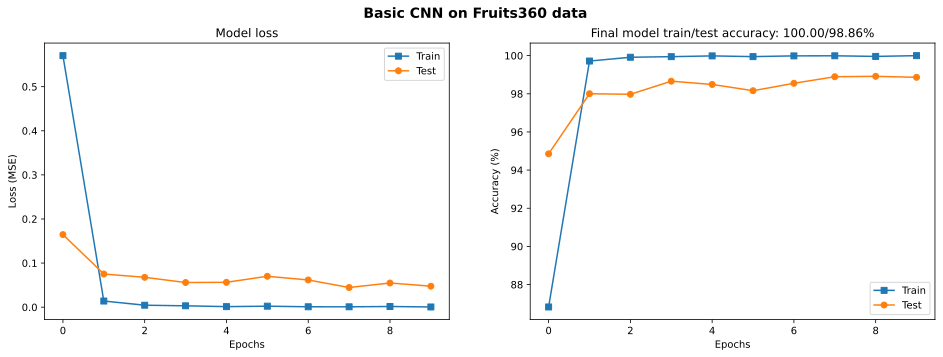

<Figure size 640x480 with 0 Axes>

In [119]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(CtrainLoss,'s-',label='Train')
ax[0].plot(CtestLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(CtrainAcc,'s-',label='Train')
ax[1].plot(CtestAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {CtrainAcc[-1]:.2f}/{CtestAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Basic CNN on Fruits360 data',fontweight='bold',fontsize=14)
plt.show()
plt.savefig('Basic_CNN.png')

### VGG16 Initial Training and Testing

In [15]:
vgg = models.vgg16(pretrained=True)
# Freeze all layers (final layer changed later)
for p in vgg.parameters():
    p.requires_grad = False
    
# change the final layer
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features,131)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
count_parameters(vgg)

536576
   131
______
536707


In [43]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg.parameters(),lr=0.01,momentum=.9)

In [44]:
import time
start_time = time.time()


numepochs = 10

# initialize losses
VtrainLoss = torch.zeros(numepochs)
VtestLoss  = torch.zeros(numepochs)
VtrainAcc  = torch.zeros(numepochs)
VtestAcc   = torch.zeros(numepochs)
Vtrain_correct = []
Vtest_correct = []


# loop over epochs
for epochi in range(numepochs):

    
    # loop over training data batches
    vgg.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    Vtrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        
        b += 1
        # forward pass and loss
        yHat = vgg(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        Vtrn_corr += batch_corr 
        
        # Print interim results
        if b%50 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {Vtrn_corr.item()*100/(100*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    VtrainLoss[epochi] = np.mean(batchLoss)
    VtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    vgg.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    Vtst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = vgg(X)
            loss = lossfun(yHat,y)
            Vtst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    VtestLoss[epochi] = np.mean(batchLoss)
    VtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {VtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   50 loss: 0.71655333 train accuracy:  52.920%
epoch:  0  batch:  100 loss: 0.93254775 train accuracy:  64.280%
epoch:  0  batch:  150 loss: 0.82309473 train accuracy:  69.413%
epoch:  0  batch:  200 loss: 0.75968379 train accuracy:  72.370%
epoch:  0  batch:  250 loss: 0.69364828 train accuracy:  74.364%
epoch:  0  batch:  300 loss: 0.52294809 train accuracy:  76.043%
epoch:  0  batch:  350 loss: 0.66087341 train accuracy:  77.286%
epoch:  0  batch:  400 loss: 1.14944482 train accuracy:  78.237%
epoch:  0  batch:  450 loss: 0.57483888 train accuracy:  79.053%
epoch:  0  batch:  500 loss: 0.59763753 train accuracy:  79.850%
epoch:  0  batch:  550 loss: 0.37575915 train accuracy:  80.551%
epoch:  0  batch:  600 loss: 0.84785807 train accuracy:  81.070%
epoch:  0  batch:  650 loss: 0.36997882 train accuracy:  81.578%
Finished epoch 1/10. Test accuracy = 90.24%
epoch:  1  batch:   50 loss: 0.47203168 train accuracy:  89.200%
epoch:  1  batch:  100 loss: 0.39834675 train 

epoch:  9  batch:  200 loss: 0.34004536 train accuracy:  93.685%
epoch:  9  batch:  250 loss: 0.30232930 train accuracy:  93.592%
epoch:  9  batch:  300 loss: 0.30267918 train accuracy:  93.623%
epoch:  9  batch:  350 loss: 0.48909381 train accuracy:  93.643%
epoch:  9  batch:  400 loss: 0.25562853 train accuracy:  93.555%
epoch:  9  batch:  450 loss: 0.55575204 train accuracy:  93.529%
epoch:  9  batch:  500 loss: 0.08233268 train accuracy:  93.604%
epoch:  9  batch:  550 loss: 0.48541820 train accuracy:  93.531%
epoch:  9  batch:  600 loss: 0.33323982 train accuracy:  93.508%
epoch:  9  batch:  650 loss: 0.39717376 train accuracy:  93.528%
Finished epoch 10/10. Test accuracy = 93.82%

Duration: 32494 seconds


In [59]:
torch.save(vgg.state_dict(), 'FRUITS-VGG-Model.pt')

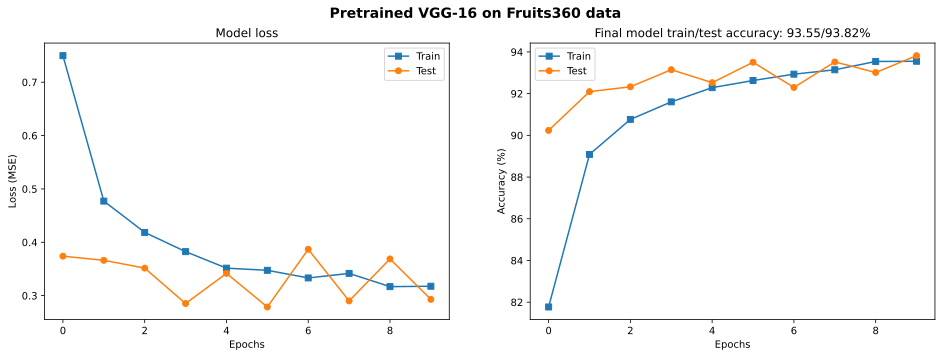

In [45]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(VtrainLoss,'s-',label='Train')
ax[0].plot(VtestLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(VtrainAcc,'s-',label='Train')
ax[1].plot(VtestAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {VtrainAcc[-1]:.2f}/{VtestAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on Fruits360 data',fontweight='bold',fontsize=14)
plt.show()
plt.savefig('FigureVGG.png')

## ResNet34 Initial Training and Testing

In [17]:
# You can use the following instead. 
weights = torchvision.models.ResNet34_Weights.DEFAULT
resnet = torchvision.models.resnet34(weights=weights)

# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False

# change the final layer
resnet.fc = nn.Linear(512,131)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
count_parameters(resnet)

 67072
   131
______
 67203


In [21]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(),lr=0.01,momentum=.9)

In [22]:
import time
start_time = time.time()


numepochs = 10

# initialize losses
RtrainLoss = torch.zeros(numepochs)
RtestLoss  = torch.zeros(numepochs)
RtrainAcc  = torch.zeros(numepochs)
RtestAcc   = torch.zeros(numepochs)
Rtrain_correct = []
Rtest_correct = []


# loop over epochs
for epochi in range(numepochs):
    
    # loop over training data batches
    resnet.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    Rtrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        
        b += 1
        
        # forward pass and loss
        yHat = resnet(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        Rtrn_corr += batch_corr 
        
        # Print interim results
        if b%50 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {Rtrn_corr.item()*100/(100*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    RtrainLoss[epochi] = np.mean(batchLoss)
    RtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    resnet.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    Rtst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = resnet(X)
            loss = lossfun(yHat,y)
            Rtst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    RtestLoss[epochi] = np.mean(batchLoss)
    RtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {RtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   50 loss: 1.19080448 train accuracy:  45.760%
epoch:  0  batch:  100 loss: 0.37083256 train accuracy:  68.420%
epoch:  0  batch:  150 loss: 0.29777589 train accuracy:  77.653%
epoch:  0  batch:  200 loss: 0.24385934 train accuracy:  82.570%
epoch:  0  batch:  250 loss: 0.20708308 train accuracy:  85.764%
epoch:  0  batch:  300 loss: 0.19075382 train accuracy:  87.970%
epoch:  0  batch:  350 loss: 0.14287367 train accuracy:  89.569%
epoch:  0  batch:  400 loss: 0.12825060 train accuracy:  90.782%
epoch:  0  batch:  450 loss: 0.08429048 train accuracy:  91.758%
epoch:  0  batch:  500 loss: 0.05518046 train accuracy:  92.524%
epoch:  0  batch:  550 loss: 0.09672737 train accuracy:  93.155%
epoch:  0  batch:  600 loss: 0.07024403 train accuracy:  93.683%
epoch:  0  batch:  650 loss: 0.06127246 train accuracy:  94.151%
Finished epoch 1/10. Test accuracy = 95.58%
epoch:  1  batch:   50 loss: 0.08151577 train accuracy:  99.600%
epoch:  1  batch:  100 loss: 0.08192253 train 

epoch:  9  batch:  200 loss: 0.01563005 train accuracy:  99.985%
epoch:  9  batch:  250 loss: 0.00668588 train accuracy:  99.984%
epoch:  9  batch:  300 loss: 0.00662065 train accuracy:  99.980%
epoch:  9  batch:  350 loss: 0.01224473 train accuracy:  99.980%
epoch:  9  batch:  400 loss: 0.00772056 train accuracy:  99.978%
epoch:  9  batch:  450 loss: 0.00436659 train accuracy:  99.976%
epoch:  9  batch:  500 loss: 0.00818152 train accuracy:  99.976%
epoch:  9  batch:  550 loss: 0.00685170 train accuracy:  99.978%
epoch:  9  batch:  600 loss: 0.00837599 train accuracy:  99.980%
epoch:  9  batch:  650 loss: 0.00780313 train accuracy:  99.978%
Finished epoch 10/10. Test accuracy = 97.45%

Duration: 43001 seconds


In [23]:
torch.save(resnet.state_dict(), 'FRUITS-RESNET34-Model.pt')

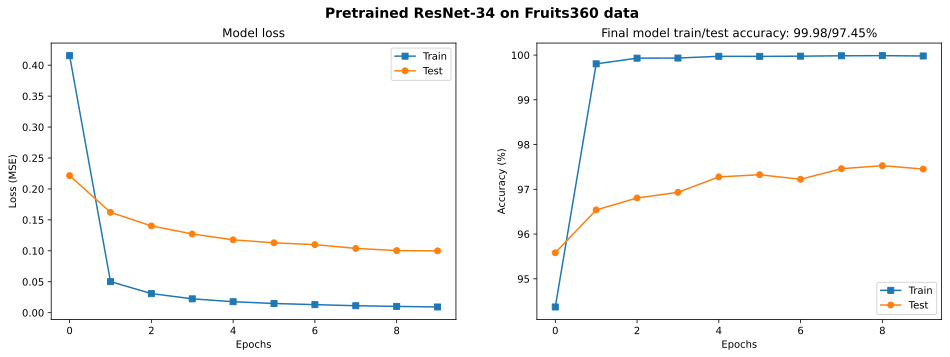

<Figure size 640x480 with 0 Axes>

In [41]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(RtrainLoss,'s-',label='Train')
ax[0].plot(RtestLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(RtrainAcc,'s-',label='Train')
ax[1].plot(RtestAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {RtrainAcc[-1]:.2f}/{RtestAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-34 on Fruits360 data',fontweight='bold',fontsize=14)
plt.show()
plt.savefig('FigureResnet34.png')

## ResNet50 Initial Training and Testing

In [21]:
# You can use the following instead. 
weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = torchvision.models.resnet50(weights=weights)

# let's inspect this network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False

# change the final layer
resnet.fc = nn.Linear(2048,131)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
count_parameters(resnet)

268288
   131
______
268419


In [54]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(),lr=0.01,momentum=.9)

In [55]:
import time
start_time = time.time()


numepochs = 10

# initialize losses
RtrainLoss = torch.zeros(numepochs)
RtestLoss  = torch.zeros(numepochs)
RtrainAcc  = torch.zeros(numepochs)
RtestAcc   = torch.zeros(numepochs)
Rtrain_correct = []
Rtest_correct = []


# loop over epochs
for epochi in range(numepochs):
    
    # loop over training data batches
    resnet.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    Rtrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        
        b += 1
        
        # forward pass and loss
        yHat = resnet(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        Rtrn_corr += batch_corr 
        
        # Print interim results
        if b%50 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {Rtrn_corr.item()*100/(100*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    RtrainLoss[epochi] = np.mean(batchLoss)
    RtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    resnet.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    Rtst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = resnet(X)
            loss = lossfun(yHat,y)
            Rtst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    RtestLoss[epochi] = np.mean(batchLoss)
    RtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {RtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   50 loss: 3.17477489 train accuracy:  33.400%
epoch:  0  batch:  100 loss: 1.97480285 train accuracy:  54.890%
epoch:  0  batch:  150 loss: 1.65920377 train accuracy:  65.867%
epoch:  0  batch:  200 loss: 1.01481962 train accuracy:  72.680%
epoch:  0  batch:  250 loss: 0.72968584 train accuracy:  77.160%
epoch:  0  batch:  300 loss: 0.69319463 train accuracy:  80.420%
epoch:  0  batch:  350 loss: 0.55368900 train accuracy:  82.703%
epoch:  0  batch:  400 loss: 0.47081566 train accuracy:  84.552%
epoch:  0  batch:  450 loss: 0.39100769 train accuracy:  85.984%
epoch:  0  batch:  500 loss: 0.26135913 train accuracy:  87.170%
epoch:  0  batch:  550 loss: 0.37485254 train accuracy:  88.184%
epoch:  0  batch:  600 loss: 0.31195500 train accuracy:  89.058%
epoch:  0  batch:  650 loss: 0.19612449 train accuracy:  89.791%
Finished epoch 1/10. Test accuracy = 92.87%
epoch:  1  batch:   50 loss: 0.23251846 train accuracy:  98.540%
epoch:  1  batch:  100 loss: 0.16170046 train 

epoch:  9  batch:  200 loss: 0.02397192 train accuracy:  99.930%
epoch:  9  batch:  250 loss: 0.07757893 train accuracy:  99.924%
epoch:  9  batch:  300 loss: 0.05380687 train accuracy:  99.923%
epoch:  9  batch:  350 loss: 0.02601326 train accuracy:  99.920%
epoch:  9  batch:  400 loss: 0.04793410 train accuracy:  99.920%
epoch:  9  batch:  450 loss: 0.02096171 train accuracy:  99.922%
epoch:  9  batch:  500 loss: 0.02214580 train accuracy:  99.916%
epoch:  9  batch:  550 loss: 0.04711604 train accuracy:  99.909%
epoch:  9  batch:  600 loss: 0.04161212 train accuracy:  99.910%
epoch:  9  batch:  650 loss: 0.01990322 train accuracy:  99.905%
Finished epoch 10/10. Test accuracy = 96.55%

Duration: 72954 seconds


In [106]:
torch.save(resnet.state_dict(), 'FRUITS-RESNET-Model.pt')

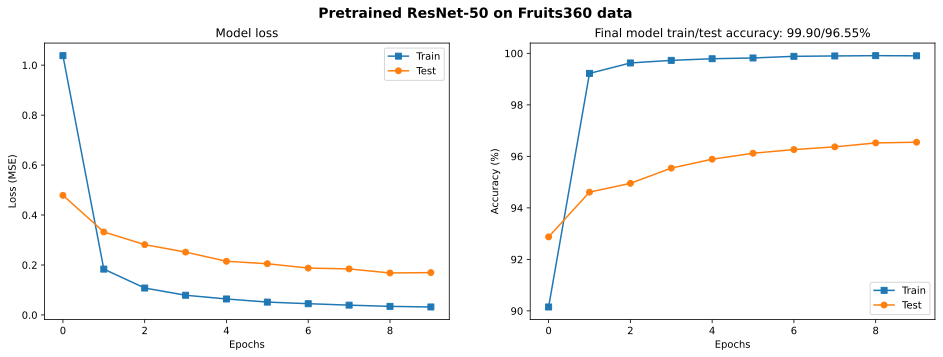

<Figure size 640x480 with 0 Axes>

In [107]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(RtrainLoss,'s-',label='Train')
ax[0].plot(RtestLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(RtrainAcc,'s-',label='Train')
ax[1].plot(RtestAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {RtrainAcc[-1]:.2f}/{RtestAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-50 on Fruits360 data',fontweight='bold',fontsize=14)
plt.show()
plt.savefig('FigureResnet.png')

# Further Training

## Basic CNN with Batchsize 32

In [16]:
# transformations
transform = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(), # normalizes to range [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # further normalization
])

In [17]:
root = '../Data/Fruit360/fruits-360_dataset/fruits-360/'

train_data = datasets.ImageFolder(os.path.join(root, 'Training'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

class_names = train_data.classes


print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')
print(f'Class types available:  {len(class_names)}')

Training images available: 67692
Testing images available:  22688
Class types available:  131


In [5]:
# create the model instance
cnn = basicCNN()
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.01,momentum=.9)

In [6]:
import time
start_time = time.time()

numepochs = 10

# initialize losses
CtrainLoss = torch.zeros(numepochs)
CtestLoss  = torch.zeros(numepochs)
CtrainAcc  = torch.zeros(numepochs)
CtestAcc   = torch.zeros(numepochs)
Ctrain_correct = []
Ctest_correct = []


# loop over epochs
for epochi in range(numepochs):
    
    # loop over training data batches
    cnn.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    Ctrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        b += 1
        # forward pass and loss
        yHat = cnn(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        Ctrn_corr += batch_corr 
        
        # Print interim results
        if b%300 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {Ctrn_corr.item()*100/(32*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    CtrainLoss[epochi] = np.mean(batchLoss)
    CtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    cnn.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    Ctst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = cnn(X)
            loss = lossfun(yHat,y)
            Ctst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    CtestLoss[epochi] = np.mean(batchLoss)
    CtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {CtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  300 loss: 0.16509847 train accuracy:  54.083%
epoch:  0  batch:  600 loss: 0.17801775 train accuracy:  72.516%
epoch:  0  batch:  900 loss: 0.05421299 train accuracy:  80.368%
epoch:  0  batch: 1200 loss: 0.05876272 train accuracy:  84.622%
epoch:  0  batch: 1500 loss: 0.02339854 train accuracy:  87.306%
epoch:  0  batch: 1800 loss: 0.00554814 train accuracy:  89.234%
epoch:  0  batch: 2100 loss: 0.00419619 train accuracy:  90.693%
Finished epoch 1/10. Test accuracy = 94.43%
epoch:  1  batch:  300 loss: 0.00639857 train accuracy:  99.500%
epoch:  1  batch:  600 loss: 0.00101474 train accuracy:  99.609%
epoch:  1  batch:  900 loss: 0.00057422 train accuracy:  99.653%
epoch:  1  batch: 1200 loss: 0.00212555 train accuracy:  99.703%
epoch:  1  batch: 1500 loss: 0.05344861 train accuracy:  99.717%
epoch:  1  batch: 1800 loss: 0.00234797 train accuracy:  99.729%
epoch:  1  batch: 2100 loss: 0.00011228 train accuracy:  99.756%
Finished epoch 2/10. Test accuracy = 98.45%
ep

## Basic CNN with Data Agumentation

In [14]:
# train transformations
transform_train = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(hue=0.4),
    transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor(), # normalizes to range [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # further normalization
])

# test transformations
transform_test = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(), # normalizes to range [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # further normalization
])

In [18]:
root = '../Data/Fruit360/fruits-360_dataset/fruits-360/'

train_data = datasets.ImageFolder(os.path.join(root, 'Training'), transform=transform_train)
test_data = datasets.ImageFolder(os.path.join(root, 'Test'), transform=transform_test)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

class_names = train_data.classes


print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')
print(f'Class types available:  {len(class_names)}')

Training images available: 67692
Testing images available:  22688
Class types available:  131


In [16]:
# create the model instance
cnn = basicCNN()
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=0.01,momentum=.9)

In [17]:
import time
start_time = time.time()

numepochs = 10

# initialize losses
CtrainLoss = torch.zeros(numepochs)
CtestLoss  = torch.zeros(numepochs)
CtrainAcc  = torch.zeros(numepochs)
CtestAcc   = torch.zeros(numepochs)
Ctrain_correct = []
Ctest_correct = []


# loop over epochs
for epochi in range(numepochs):
    
    # loop over training data batches
    cnn.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    Ctrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        b += 1
        # forward pass and loss
        yHat = cnn(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        Ctrn_corr += batch_corr 
        
        # Print interim results
        if b%300 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {Ctrn_corr.item()*100/(100*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    CtrainLoss[epochi] = np.mean(batchLoss)
    CtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    cnn.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    Ctst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = cnn(X)
            loss = lossfun(yHat,y)
            Ctst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    CtestLoss[epochi] = np.mean(batchLoss)
    CtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {CtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  300 loss: 0.71017039 train accuracy:  42.023%
epoch:  0  batch:  600 loss: 0.20436464 train accuracy:  64.802%
Finished epoch 1/10. Test accuracy = 85.65%
epoch:  1  batch:  300 loss: 0.07304914 train accuracy:  96.473%
epoch:  1  batch:  600 loss: 0.03413671 train accuracy:  97.183%
Finished epoch 2/10. Test accuracy = 85.69%
epoch:  2  batch:  300 loss: 0.01299843 train accuracy:  98.570%
epoch:  2  batch:  600 loss: 0.00482858 train accuracy:  98.893%
Finished epoch 3/10. Test accuracy = 94.57%
epoch:  3  batch:  300 loss: 0.02039841 train accuracy:  99.250%
epoch:  3  batch:  600 loss: 0.04747273 train accuracy:  99.277%
Finished epoch 4/10. Test accuracy = 92.64%
epoch:  4  batch:  300 loss: 0.01539907 train accuracy:  99.497%
epoch:  4  batch:  600 loss: 0.00806915 train accuracy:  99.582%
Finished epoch 5/10. Test accuracy = 94.56%
epoch:  5  batch:  300 loss: 0.00713794 train accuracy:  99.777%
epoch:  5  batch:  600 loss: 0.00366056 train accuracy:  99.740%


## VGG16 Improving

In [8]:
vggmodel2 = vgg
vggmodel2.load_state_dict(torch.load('FRUITS-VGG-Model.pt'))
vggmodel2.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
vggmodel3 = vgg
vggmodel3.load_state_dict(torch.load('../Assignment2/FRUITS-VGG-Model.pt'))
vggmodel3.eval()
for p in vggmodel3.parameters():
    p.requires_grad = True

In [8]:
count_parameters(vggmodel3)

  1728
    64
 36864
    64
 73728
   128
147456
   128
294912
   256
589824
   256
589824
   256
1179648
   512
2359296
   512
2359296
   512
2359296
   512
2359296
   512
2359296
   512
102760448
  4096
16777216
  4096
536576
   131
______
134797251


In [9]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vggmodel3.parameters(),lr=0.001,momentum=.9)

In [ ]:
import time
start_time = time.time()


numepochs = 6

# initialize losses
VNtrainLoss = torch.zeros(numepochs)
VNtestLoss  = torch.zeros(numepochs)
VNtrainAcc  = torch.zeros(numepochs)
VNtestAcc   = torch.zeros(numepochs)
VNtrain_correct = []
VNtest_correct = []


# loop over epochs
for epochi in range(numepochs):

    
    # loop over training data batches
    vggmodel3.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    VNtrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        
        b += 1
        # forward pass and loss
        yHat = vggmodel3(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        VNtrn_corr += batch_corr 
        
        # Print interim results
        if b%100 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {VNtrn_corr.item()*100/(100*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    VNtrainLoss[epochi] = np.mean(batchLoss)
    VNtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    vggmodel3.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    VNtst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = vggmodel3(X)
            loss = lossfun(yHat,y)
            VNtst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    VNtestLoss[epochi] = np.mean(batchLoss)
    VNtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {VNtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  100 loss: 0.14472741 train accuracy:  93.590%
epoch:  0  batch:  200 loss: 0.03873213 train accuracy:  95.565%
epoch:  0  batch:  300 loss: 0.03582239 train accuracy:  96.563%
epoch:  0  batch:  400 loss: 0.00502998 train accuracy:  97.177%
epoch:  0  batch:  500 loss: 0.01891565 train accuracy:  97.606%
epoch:  0  batch:  600 loss: 0.00445645 train accuracy:  97.890%
Finished epoch 1/6. Test accuracy = 97.21%
epoch:  1  batch:  100 loss: 0.01518642 train accuracy:  99.420%
epoch:  1  batch:  200 loss: 0.00570867 train accuracy:  99.585%
epoch:  1  batch:  300 loss: 0.00110269 train accuracy:  99.673%
epoch:  1  batch:  400 loss: 0.00485471 train accuracy:  99.698%
epoch:  1  batch:  500 loss: 0.00009800 train accuracy:  99.742%
epoch:  1  batch:  600 loss: 0.00487121 train accuracy:  99.755%
Finished epoch 2/6. Test accuracy = 97.95%
epoch:  2  batch:  100 loss: 0.00001567 train accuracy:  99.760%
epoch:  2  batch:  200 loss: 0.00021786 train accuracy:  99.840%
epoc

## ResNet 34 Improving

In [42]:
resnet34model2 = resnet
resnet34model2.load_state_dict(torch.load('FRUITS-RESNET34-Model.pt'))
resnet34model2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
resnet34model3 = resnet
resnet34model3.load_state_dict(torch.load('FRUITS-RESNET34-Model.pt'))
resnet34model3.eval()

for p in resnet34model3.parameters():
    p.requires_grad = True

In [7]:
count_parameters(resnet34model3)

  9408
    64
    64
 36864
    64
    64
 36864
    64
    64
 36864
    64
    64
 36864
    64
    64
 36864
    64
    64
 36864
    64
    64
 73728
   128
   128
147456
   128
   128
  8192
   128
   128
147456
   128
   128
147456
   128
   128
147456
   128
   128
147456
   128
   128
147456
   128
   128
147456
   128
   128
294912
   256
   256
589824
   256
   256
 32768
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
589824
   256
   256
1179648
   512
   512
2359296
   512
   512
131072
   512
   512
2359296
   512
   512
2359296
   512
   512
2359296
   512
   512
2359296
   512
   512
 67072
   131
______
21351875


In [8]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet34model3.parameters(),lr=0.001,momentum=.9)

In [ ]:
import time
start_time = time.time()

numepochs = 6

# initialize losses
RNtrainLoss = torch.zeros(numepochs)
RNtestLoss  = torch.zeros(numepochs)
RNtrainAcc  = torch.zeros(numepochs)
RNtestAcc   = torch.zeros(numepochs)
RNtrain_correct = []
RNtest_correct = []


# loop over epochs
for epochi in range(numepochs):

    
    # loop over training data batches
    resnet34model3.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    RNtrn_corr = 0
    
    for b, (X,y) in enumerate(train_loader):
        
        b += 1
        # forward pass and loss
        yHat = resnet34model3(X)
        loss = lossfun(yHat,y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        batch_corr = (torch.argmax(yHat,axis=1) == y).sum()
        RNtrn_corr += batch_corr 
        
        # Print interim results
        if b%100 == 0:
            print(f'epoch: {epochi:2}  batch: {b:4} loss: {loss.item():10.8f} train accuracy: {RNtrn_corr.item()*100/(100*b):7.3f}%')

      # end of batch loop...

    # and get average losses and accuracies across the batches
    RNtrainLoss[epochi] = np.mean(batchLoss)
    RNtrainAcc[epochi]  = 100*np.mean(batchAcc)

    
    #### test performance (here done in batches!)
    resnet34model3.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    RNtst_corr = 0
    
    for b,(X,y) in enumerate(test_loader):
        # forward pass and loss
        with torch.no_grad():
            yHat = resnet34model3(X)
            loss = lossfun(yHat,y)
            RNtst_corr += (torch.argmax(yHat,axis=1) == y).sum()
            
        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    
    # and get average losses and accuracies across the batches
    RNtestLoss[epochi] = np.mean(batchLoss)
    RNtestAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {RNtestAcc[epochi]:.2f}%')

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  100 loss: 0.00245445 train accuracy:  99.990%
epoch:  0  batch:  200 loss: 0.00278918 train accuracy:  99.995%
epoch:  0  batch:  300 loss: 0.00432459 train accuracy:  99.993%
epoch:  0  batch:  400 loss: 0.00247863 train accuracy:  99.993%
epoch:  0  batch:  500 loss: 0.00176888 train accuracy:  99.994%
epoch:  0  batch:  600 loss: 0.00221308 train accuracy:  99.993%
Finished epoch 1/6. Test accuracy = 98.37%
epoch:  1  batch:  100 loss: 0.00201831 train accuracy: 100.000%
epoch:  1  batch:  200 loss: 0.00205715 train accuracy: 100.000%
epoch:  1  batch:  300 loss: 0.00129440 train accuracy:  99.993%
epoch:  1  batch:  400 loss: 0.00180181 train accuracy:  99.995%
epoch:  1  batch:  500 loss: 0.00132285 train accuracy:  99.996%
epoch:  1  batch:  600 loss: 0.00181155 train accuracy:  99.997%
Finished epoch 2/6. Test accuracy = 98.48%
epoch:  2  batch:  100 loss: 0.00082865 train accuracy: 100.000%
epoch:  2  batch:  200 loss: 0.00166922 train accuracy: 100.000%
epoc

## Examine the miss

2


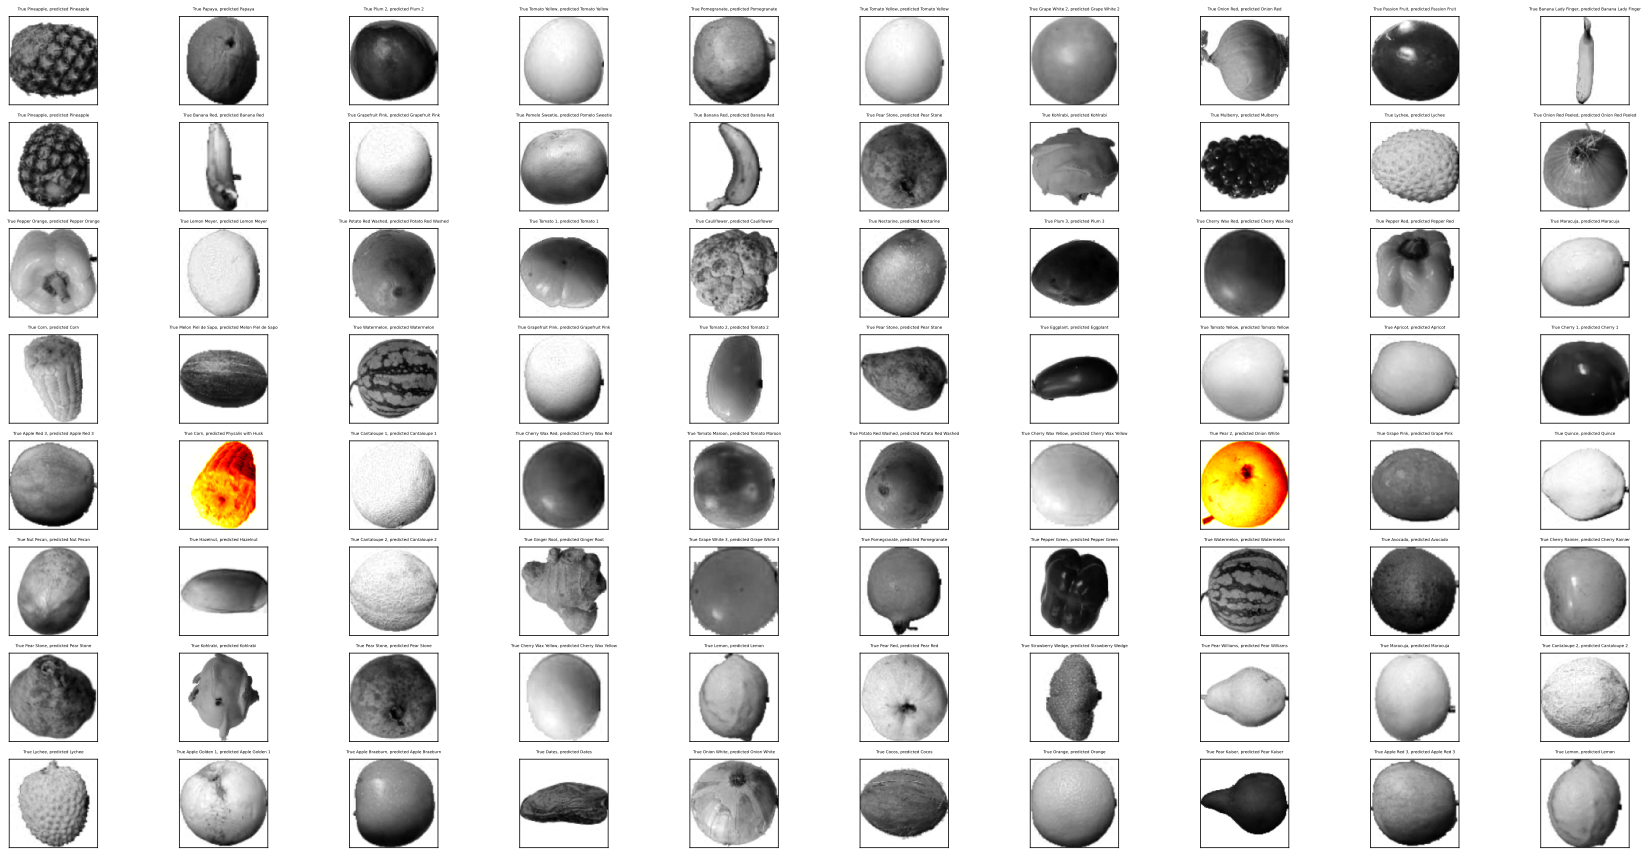

In [53]:
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
yHat = vggmodel3(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=80,replace=False)

# visualize some images
fig,axs = plt.subplots(8,10,figsize=(30,15))


for i,ax in enumerate(axs.flatten()):
    # extract the image and its target letter
    I = np.squeeze( X[randex[i],0,:,:])
    trueClass = class_names[ y[randex[i]] ]
    predClass = class_names[ torch.argmax(yHat[randex[i],:]) ]

    # color-code the accuracy (using ternary operator)
    col = 'gray' if trueClass==predClass else 'hot'


    # visualize
    ax.imshow(I.T,cmap=col)
    ax.set_title('True %s, predicted %s' %(trueClass,predClass),fontsize=4)
    ax.set_xticks([])
    ax.set_yticks([])

    
print(len(misses))
plt.savefig('test_wrong.png')
plt.show()